# Pipeline - Kildisuite Neuroblastoma Data

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ranksums
import statistics

In [201]:
def ReadFiles():
    # Read the h5ad file for neuroblastoma data
    nb_data = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/nb_GOSH_cellxgene.h5ad")

    #Read the h5ad file for adrenal gland data
    ag_data = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/adr_all_cellxgene.h5ad")
    
    maxima_nb = sc.read_h5ad("/Users/davidkaplan/Desktop/neuroblastoma_data/kildisuite/nb_PMC_cellxgene.h5ad")

    print(maxima_nb.obs['Annotation'])
    print(maxima_nb.var.head(5))

    return nb_data, ag_data, maxima_nb

In [202]:
def QualityControlMetrics(data):
    sns.set(style="darkgrid")
    print(data.obs.columns)
    data.var['mt'] = data.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(data,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    sns.boxplot(data.obs['n_genes_by_counts'],ax=axes[0])
    sns.boxplot(data.obs['nCount_RNA'],ax=axes[1])
    sns.boxplot(data.obs['pct_counts_mt'],ax=axes[2])
    sc.pl.violin(data,['n_genes_by_counts','nCount_RNA','pct_counts_mt'],jitter=0.4,multi_panel=True)
    sc.pl.scatter(data,x='nCount_RNA',y='n_genes_by_counts',color='pct_counts_mt')
    sns.distplot(data.obs['n_genes_by_counts'])
    sns.jointplot(y="n_genes_by_counts",x="nCount_RNA",data=data.obs,kind="scatter",s=5)
    
    return data

In [203]:
def n_genes_filter(data):
    upper = np.quantile(data.obs.n_genes_by_counts.values, .98)
    lower = np.quantile(data.obs.n_genes_by_counts.values, .02)
    median = statistics.median(data.obs.n_genes_by_counts)
    MAD = data.obs.n_genes_by_counts.mad()
    lowMAD = median - (3*MAD)
    highMAD = median + (3*MAD)
    
    print("Range: "+str(lowMAD)+" to "+str(highMAD))
    
    print("Range: "+str(lower)+" to "+str(upper))
    #data = data[(data.obs.n_genes_by_counts < upper) & (data.obs.n_genes_by_counts > lower)]
    return data

In [204]:
def OcasioMitoFiltering(data):
    #Version 1 - Ocasio et al., 2019
    median = statistics.median(data.obs.pct_counts_mt)
    print(median)
    sd = statistics.stdev(data.obs.pct_counts_mt)
    upper_lim = median + (sd * 3)
    lower_lim = median - (sd* 3)
    if lower_lim < 0:
        lower_lim = 0
    print("Range: "+str(lower_lim)+" to "+str(upper_lim))
    data = data[data.obs.pct_counts_mt < upper_lim, :]
    return data

In [205]:
def YouMitoFiltering(data):
    # Version 2 - You et al., 2021
    median = statistics.median(data.obs.pct_counts_mt)
    med = data.obs.pct_counts_mt.median()
    MAD = data.obs.pct_counts_mt.mad()
    print(med,MAD)
    filter_mt = (median + (3*MAD))
    print("Upper",filter_mt)
    data = data[data.obs.pct_counts_mt < filter_mt, :]
    return data

In [206]:
def FilteringCheck(data):
    sc.pl.scatter(data,x='nCount_RNA',y='n_genes_by_counts',color='pct_counts_mt')

In [207]:
def IntegrateData(datasets):
    dict_data = {}
    for i in range(0,len(datasets)-1):
        for j in range(i,len(datasets)):
            if datasets[i].shape[0] < datasets[j].shape[0]:
                datasets[i], datasets[j] = datasets[j], datasets[i]
                print("Re positioned dataset ", i ,"to ",j)
    print(datasets[0].shape,datasets[1].shape,datasets[2].shape)
    
    data_kildisuite = datasets[0].concatenate(datasets[1], batch_key='sample')
    data_kildisuite = data_kildisuite.concatenate(datasets[2], batch_key ='sample')
    
    return data_kildisuite
    
    # for x in range(0,len(datasets)):
    #     if datasets[x].shape[0] == 56395:
    #         print("ag_data")
    #         data_kildisuite = datasets[x].concatenate(datasets[-1], batch_key='sample')
                
    # return data_kildisuite

In [208]:
def NormalizeData(data_kildisuite):
    sc.pp.normalize_total(data_kildisuite, target_sum=1e4)
    sc.pp.log1p(data_kildisuite)
    data_kildisuite.raw = data_kildisuite
    return data_kildisuite

In [209]:
def HVG(data_kildisuite):
    sc.pp.highly_variable_genes(data_kildisuite, min_mean=0.0125,max_mean=3,min_disp=0.5,batch_key='sample')
    sc.pl.highly_variable_genes(data_kildisuite)
    highly_variable_data = data_kildisuite[:,data_kildisuite.var.highly_variable]
    return highly_variable_data

In [210]:
def PCA(data):
    pcData = data.copy()
    sc.pp.scale(pcData, max_value=10)
    sc.tl.pca(pcData,svd_solver='arpack')
    sc.pl.pca(pcData,color="Annotation",components=['1,2','3,4'],ncols=1)
    sc.pl.pca_loadings(pcData,components=[1,2,3,4,5,6,7,8])
    sc.pl.pca_variance_ratio(pcData,log=True,n_pcs=50,save='var_ratio50.pdf')
    return pcData
    

In [211]:
def UMAP(pcData):
    sc.pp.neighbors(pcData, n_pcs=10)
    sc.tl.umap(pcData,n_components=10,min_dist=0.1)
    sc.pl.umap(pcData, color='Annotation',components=['1,2','3,4'],ncols=1)
    return pcData

In [212]:
def RankGeneGroups(pcData):
    sc.tl.rank_genes_groups(pcData, 'Annotation', method='wilcoxon')
    sc.set_figure_params(figsize=(8,4))
    sc.pl.rank_genes_groups(pcData, n_genes=25,sharey=False,save='25_genes_rank.pdf',ncols=5)
    plt.show()
    pd.DataFrame(pcData.uns['rank_genes_groups']['names']).head(5)
    names_csv = pd.DataFrame(pcData.uns['rank_genes_groups']['names'])
    names = pcData.uns['rank_genes_groups']['names'][0]
    print(names)
    sc.pl.violin(pcData, names,groupby='Annotation',ncols=2,rotation=45)
    sc.pl.rank_genes_groups_heatmap(pcData,n_genes=20,groupby="Annotation",show_gene_labels=True)
    return pcData, names_csv

In [213]:
def WriteCSV(data):
    top5 = data.head(5)
    top5.to_csv('output.csv')

In [214]:
def Main():
    nb_data,ag_data,maxima_nb = ReadFiles()
    processed_data = []
    datasets = [nb_data,ag_data,maxima_nb]
    for i,dataset in enumerate(datasets):
        data = QualityControlMetrics(dataset)
        data = n_genes_filter(data)
        if i == 1 or i == 2:
            data = YouMitoFiltering(data)
            # FilteringCheck(data)
        processed_data.append(data)
    
    combined_data = IntegrateData(processed_data)
    data_kildisuite = NormalizeData(combined_data)
    highly_variable_data = HVG(data_kildisuite)
    pcData = PCA(highly_variable_data)
    pc_umap_data = UMAP(pcData)
    final_data,topgenes = RankGeneGroups(pc_umap_data)
    WriteCSV(topgenes) 
    
    
    
    # nb_data = processed_data[0]

    # # ag_data = processed_data[1]
            

index
TM36-C10           Leukocytes
TM36-F5            Leukocytes
TM36-F8            Leukocytes
TM36-G4            Leukocytes
TM36-H18           Leukocytes
                   ...       
TM231-P7     Tumour cluster 3
TM231-P9     Tumour cluster 3
TM231-P10    Tumour cluster 3
TM231-P11    Tumour cluster 3
TM231-P13    Tumour cluster 3
Name: Annotation, Length: 13281, dtype: category
Categories (9, object): [Tumour cluster 1, Tumour cluster 2, Tumour cluster 3, Ambiguous 1, ..., Schwannian stroma, Endothelium, Mesenchyme, Leukocytes]
          vst.mean  vst.variance  vst.variance.expected  \
index                                                     
TSPAN6    0.146224      0.376358               0.333401   
TNMD      0.002492      0.034723               0.003406   
DPM1      0.241849      0.393462               0.623210   
SCYL3     0.079738      0.130614               0.165969   
C1orf112  0.023266      0.038992               0.042516   

          vst.variance.standardized  vst.variabl

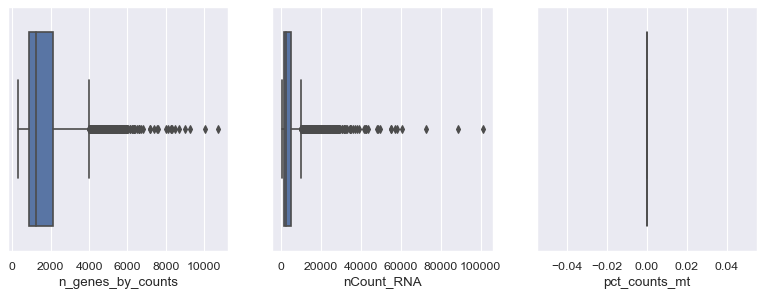

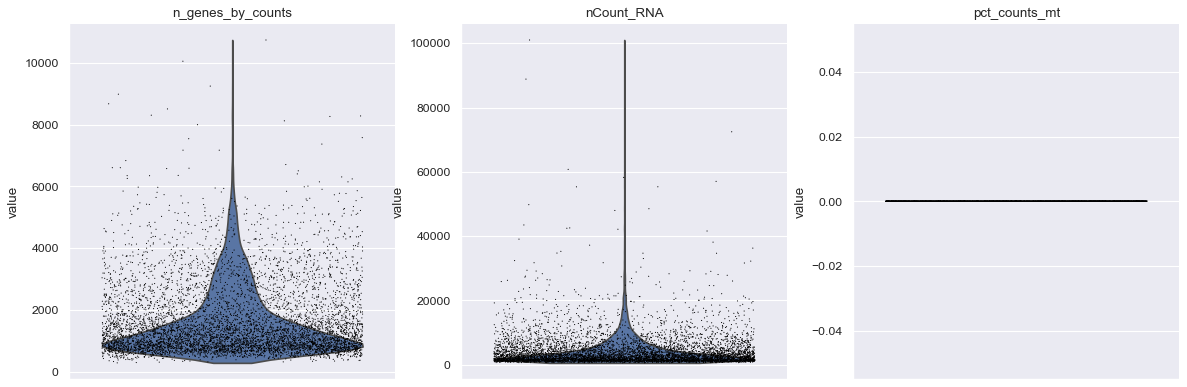

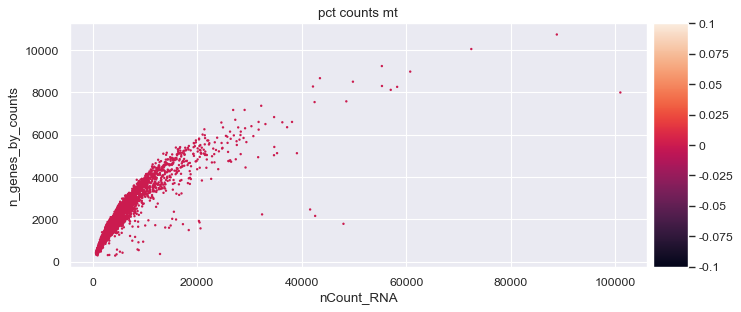

Range: -1357.8745811140625 to 3859.8745811140625
Range: 509.82 to 4957.700000000004
Index(['GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA',
       'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes'],
      dtype='object')


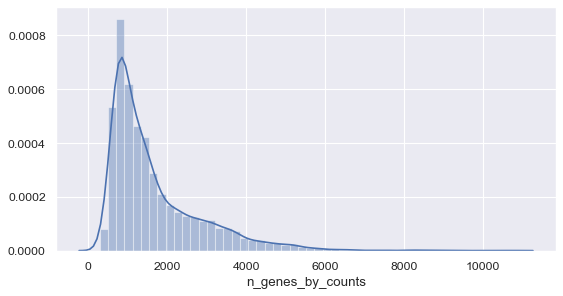

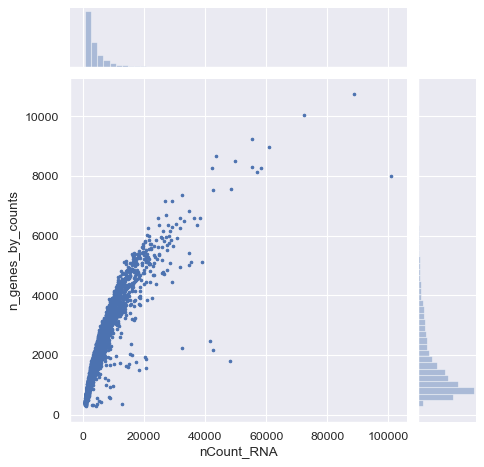

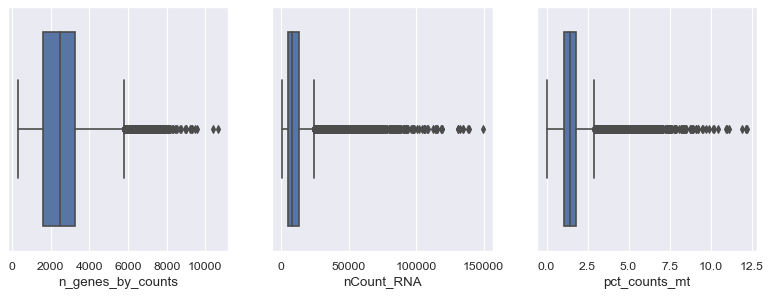

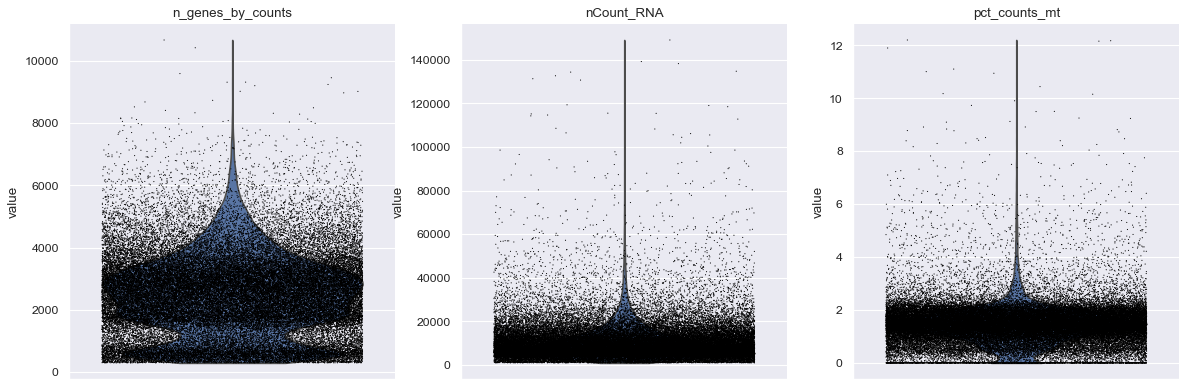

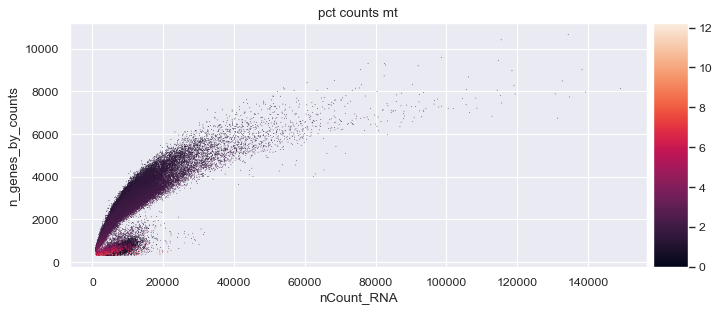

Range: -627.257120958172 to 5549.257120958172
Range: 384.0 to 5408.0
1.4421005 0.514275
Upper 2.9849255681037903
Index(['SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes',
       'hspGenes', 'riboGenes'],
      dtype='object')


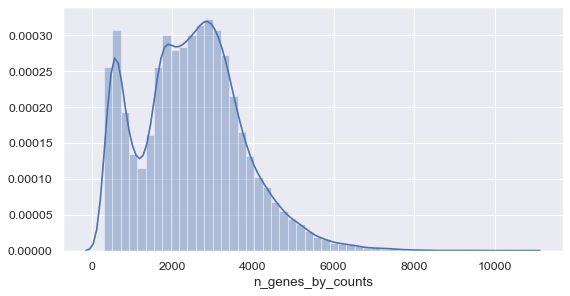

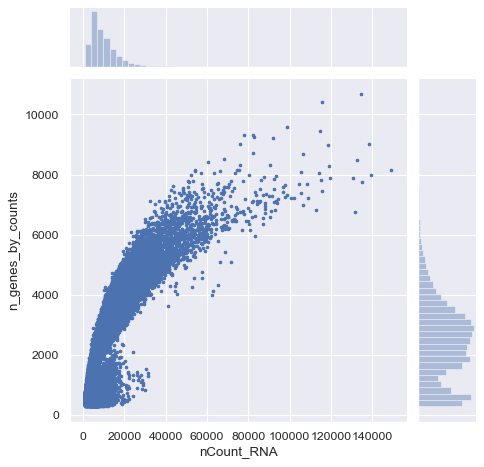

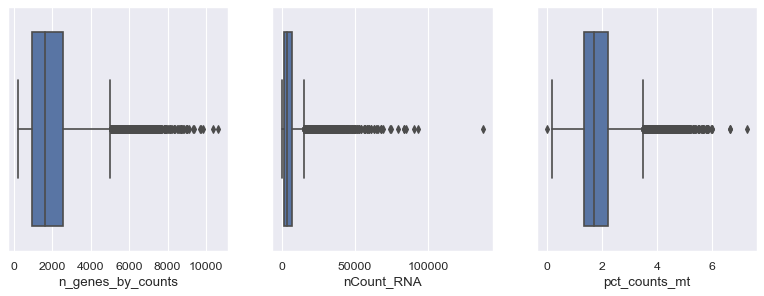

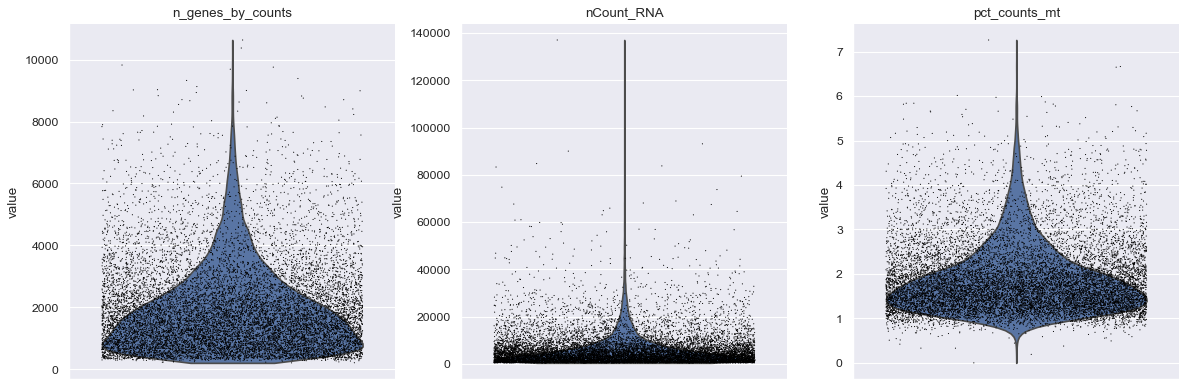

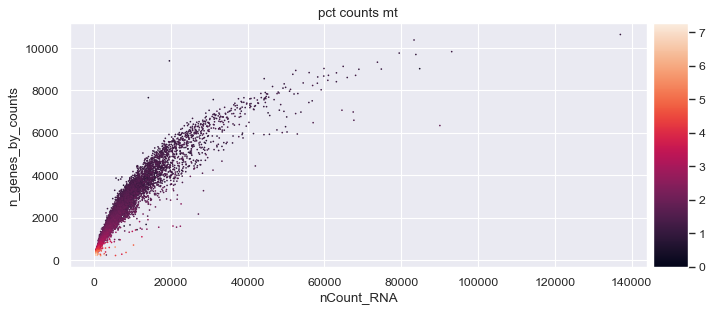

Range: -1529.7621335472022 to 4775.762133547202
Range: 368.0 to 5972.4
1.7080462 0.58486134
Upper 3.4626302123069763
Re positioned dataset  0 to  1
Re positioned dataset  1 to  2
(56395, 33694) (12586, 32383) (6442, 33428)


... storing 'GestationalAge' as categorical
... storing 'SampleName' as categorical
... storing 'Annotation' as categorical


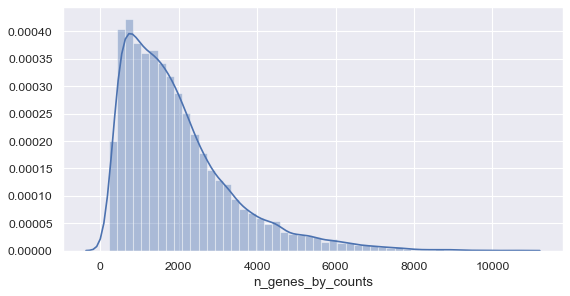

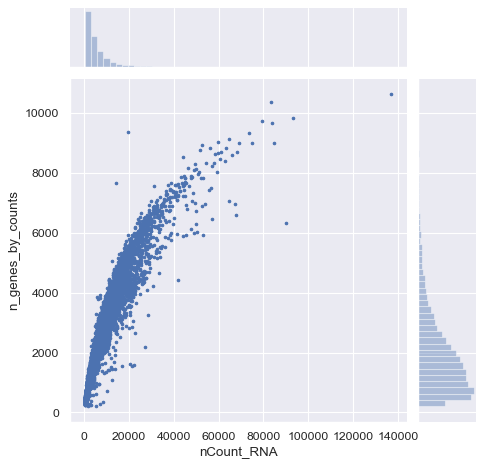

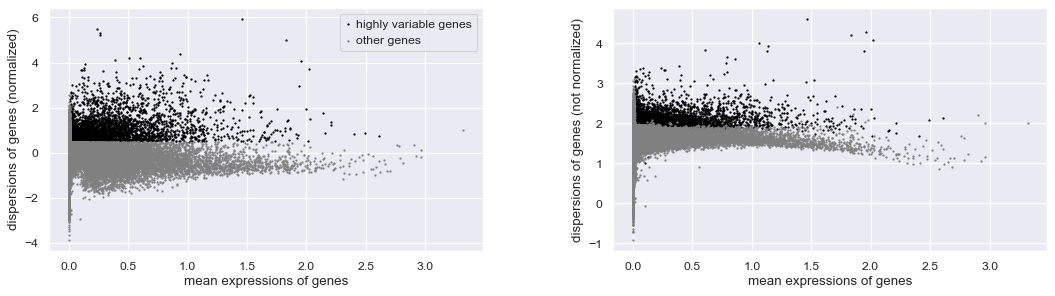

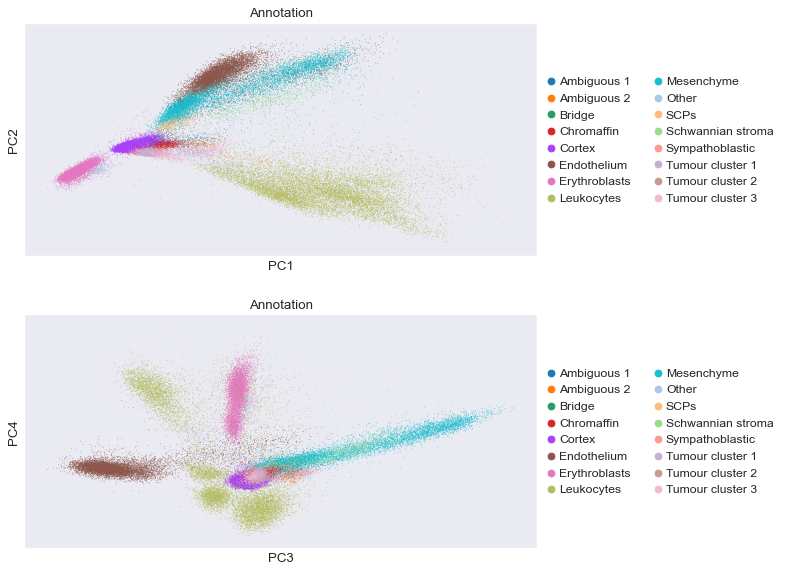

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


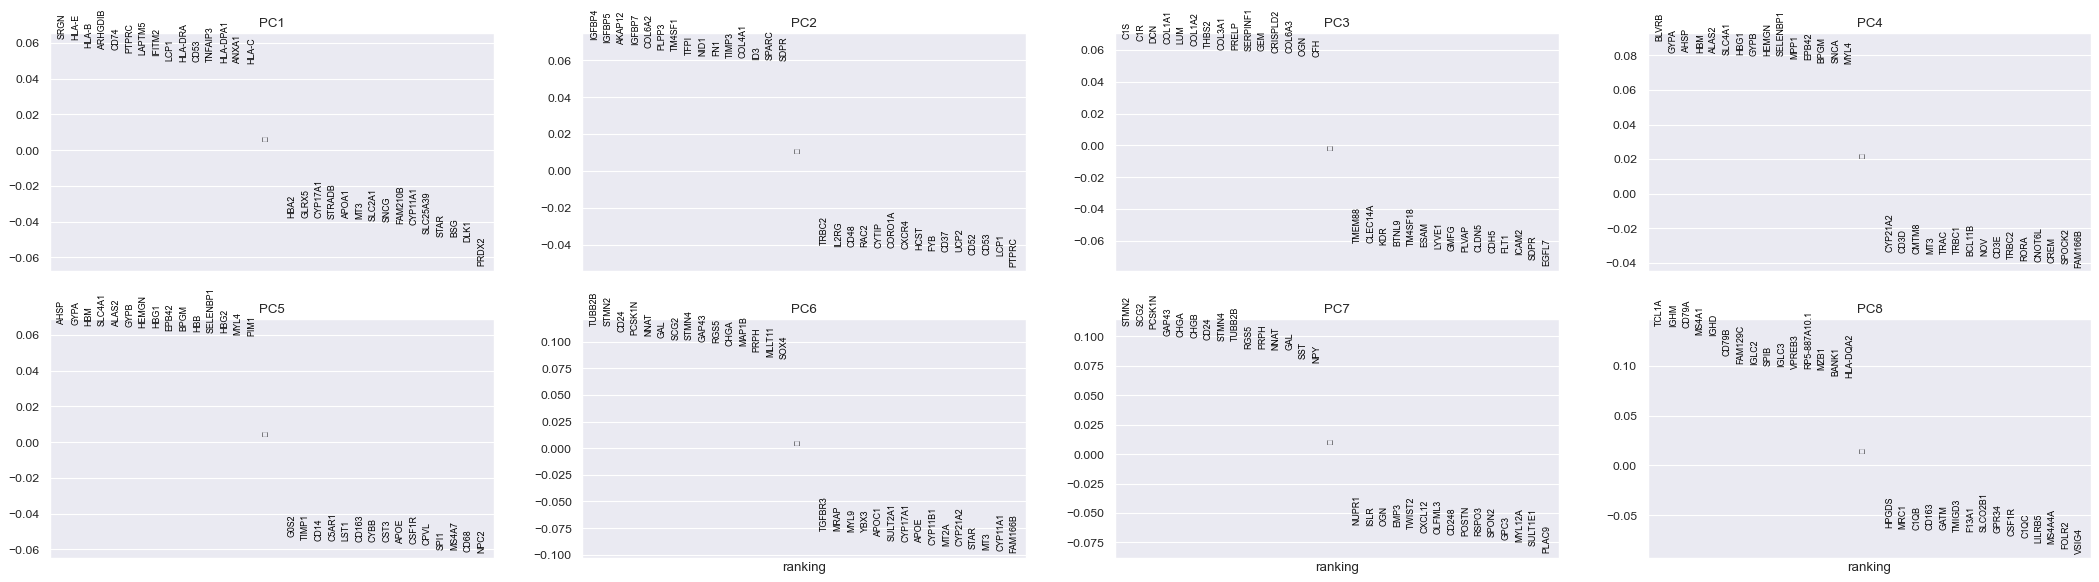

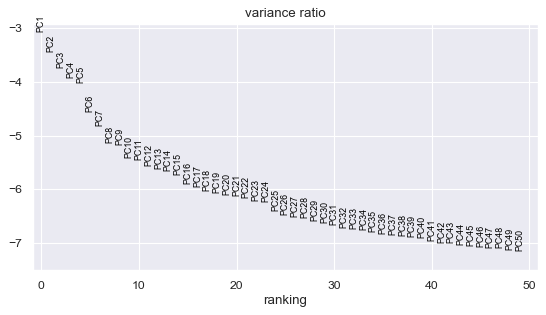

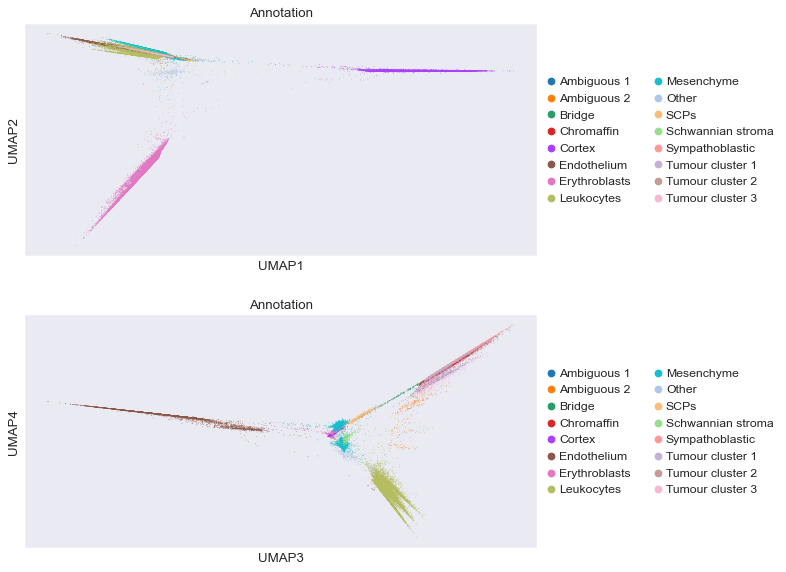

In [215]:
Main()